# **Predicción de Cálculos Biliares para Zonas Rurales (Evaluación In Situ)**

**Objetivo:** Crear y validar un modelo de Machine Learning para la detección temprana de cálculos biliares utilizando **únicamente** variables que pueden ser medidas en un entorno rural o con recursos limitados. Se asume la disponibilidad de equipo básico (báscula, tallímetro), un cuestionario de historial médico y un analizador de bioimpedancia portátil.

**Metodología Simplificada:**
1.  **Carga y Filtrado de Datos:** Se carga el dataset completo y se descartan todas las variables que requieren un análisis de laboratorio. Nos quedamos solo con datos demográficos, antropométricos y de bioimpedancia.
2.  **Modelo de Referencia (Benchmark):** Se entrenan varios modelos estándar con una búsqueda de hiperparámetros (`GridSearchCV`) para establecer un rendimiento base con nuestro conjunto de datos reducido.
3.  **Estrategia de Optimización (SMOTE + Optuna):** Para mejorar el rendimiento, se aplica una técnica avanzada que combina:
    *   **SMOTE:** Para corregir el desbalance de clases en el conjunto de entrenamiento, creando datos sintéticos de la clase minoritaria.
    *   **Optuna:** Para realizar una búsqueda de hiperparámetros mucho más eficiente y exhaustiva que el GridSearchCV.
4.  **Evaluación e Interpretabilidad (SHAP):** Se evalúa el modelo final y se utiliza la librería `SHAP` para entender qué mediciones *in situ* son las más importantes para predecir el riesgo, ofreciendo información clave para el personal de salud en campo.

In [1]:
# --- 1. INSTALACIÓN DE LIBRERÍAS ---
# Se instalan las librerías para modelado, optimización, manejo de desbalance e interpretabilidad.
!pip install catboost optuna imbalanced-learn shap -q
print("Librerías necesarias instaladas.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.2 MB/s eta 0:00:00
Librerías necesarias instaladas.


In [2]:
# --- 2. IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [10]:
# --- 3. CARGA Y FILTRADO DE DATOS PARA ENTORNO RURAL ---
# NOTA: Asegúrate de haber subido el archivo 'dataset-uci.xlsx' a tu sesión de Colab.
try:
    df = pd.read_excel('dataset-uci.xlsx', sheet_name="dataset")
except FileNotFoundError:
    print("Error: El archivo 'dataset-uci.xlsx' no se encontró.")
    print("Por favor, súbelo al panel de archivos a la izquierda y vuelve a ejecutar la celda.")
    df = pd.DataFrame() # Previene errores en las celdas siguientes

# --- DEFINICIÓN DE CARACTERÍSTICAS MEDIBLES IN SITU ---
# Se seleccionan solo las variables que no requieren un laboratorio.
# Esto incluye datos demográficos, historial médico (comorbilidades) y mediciones de bioimpedancia.
features_rurales = [
    'GallstoneStatus', 'Age', 'Gender', 'Comorbidity', 'CAD', 'Hypothyroidism',
    'Hyperlipidemia', 'DM', 'Height', 'Weight', 'BMI', 'TBW', 'ECW', 'ICW',
    'ECF_TBW', 'TBFR', 'LM', 'Protein', 'VFR', 'BM', 'MM', 'Obesity', 'TFC',
    'VFA', 'VMA', 'HFA'
]

# Filtramos el DataFrame para quedarnos solo con estas columnas
if not df.empty:
    df_rural = df[features_rurales].copy()

    print(f'Dataset original cargado con dimensiones: {df.shape}')
    print(f'Dataset filtrado para contexto rural con dimensiones: {df_rural.shape}')

    # Separar características (X) y variable objetivo (y)
    X = df_rural.drop(columns=['GallstoneStatus'])
    y = df_rural['GallstoneStatus']

    # Verificar el balance de clases
    print("\nDistribución de la variable objetivo (y): 0=Sano, 1=Con Cálculos")
    print(y.value_counts())

Dataset original cargado con dimensiones: (319, 39)
Dataset filtrado para contexto rural con dimensiones: (319, 26)

Distribución de la variable objetivo (y): 0=Sano, 1=Con Cálculos
GallstoneStatus
0    161
1    158
Name: count, dtype: int64


In [11]:
# --- 4. DIVISIÓN Y ESCALADO DE DATOS ---
# Dividimos los datos filtrados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Se escalan las características para que los modelos funcionen correctamente.
# Es fundamental ajustar el escalador (fit) SOLO con los datos de entrenamiento.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

print("Datos divididos y escalados.")
print(f"Tamaño del conjunto de entrenamiento: {X_train_scaled.shape}")
print(f"Tamaño del conjunto de prueba: {X_test_scaled.shape}")

Datos divididos y escalados.
Tamaño del conjunto de entrenamiento: (223, 25)
Tamaño del conjunto de prueba: (96, 25)


In [12]:
# --- 5. BÚSQUEDA DE MODELO DE REFERENCIA CON GRIDSEARCHCV ---
# El objetivo de esta celda es encontrar el MEJOR TIPO de modelo para nuestro set de datos rurales.

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [5, 10]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.05, 0.1]}
}

print("--- Iniciando Búsqueda de Modelo de Referencia sobre Datos Rurales ---")
resultados_benchmark_list = []

for nombre, modelo in models.items():
    print(f"Evaluando {nombre}...")
    grid_search = GridSearchCV(modelo, param_grids[nombre], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)
    y_test_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

    resultados_benchmark_list.append({
        "Modelo": nombre,
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test AUC": roc_auc_score(y_test, y_test_proba),
        "Mejores Parámetros": grid_search.best_params_
    })

resultados_benchmark_df = pd.DataFrame(resultados_benchmark_list).sort_values(by='Test Accuracy', ascending=False)
print("\n--- Resultados del Benchmark ---")
display(resultados_benchmark_df)

--- Iniciando Búsqueda de Modelo de Referencia sobre Datos Rurales ---
Evaluando Logistic Regression...
Evaluando Random Forest...
Evaluando Gradient Boosting...
Evaluando XGBoost...
Evaluando CatBoost...

--- Resultados del Benchmark ---


,Modelo,Test Accuracy,Test AUC,Mejores Parámetros
3,XGBoost,0.750000,0.806858,"{'learning_rate': 0.1, 'n_estimators': 200}"
4,CatBoost,0.729167,0.799045,"{'iterations': 200, 'learning_rate': 0.1}"
0,Logistic Regression,0.718750,0.788628,{'C': 1}
2,Gradient Boosting,0.708333,0.801215,"{'learning_rate': 0.1, 'n_estimators': 200}"
1,Random Forest,0.708333,0.795139,"{'max_depth': 10, 'n_estimators': 100}"


In [13]:
# --- 6. ESTRATEGIA DE OPTIMIZACIÓN: SMOTE + OPTUNA ---
print("\n--- Estrategia de Mejora: Aumento de Datos con SMOTE y Búsqueda con Optuna ---")

# 1. Aplicar SMOTE para balancear el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Tamaño del conjunto de entrenamiento original: {X_train_scaled.shape}")
print(f"Distribución de clases original:\n{y_train.value_counts()}\n")
print(f"Tamaño del conjunto de entrenamiento tras SMOTE: {X_train_smote.shape}")
print(f"Distribución de clases con SMOTE:\n{y_train_smote.value_counts()}\n")

# 2. Definir la función objetivo para Optuna (usando el mejor tipo de modelo del benchmark)
mejor_modelo_nombre = resultados_benchmark_df.iloc[0]['Modelo']
print(f"Optimizando hiperparámetros para: Gradient Boosting (suele ser el más robusto)")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 32),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }
    model = GradientBoostingClassifier(random_state=42, **params)
    score = cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, cv=5, scoring='accuracy').mean()
    return score

# 3. Ejecutar el estudio de Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nMejor accuracy en validación cruzada (Optuna): {study.best_value:.4f}")
print(f"Mejores hiperparámetros encontrados: {study.best_params}")

# 4. Entrenar y evaluar el modelo final optimizado
final_model_optuna = GradientBoostingClassifier(random_state=42, **study.best_params)
final_model_optuna.fit(X_train_smote, y_train_smote)

y_pred_optuna = final_model_optuna.predict(X_test_scaled)
y_proba_optuna = final_model_optuna.predict_proba(X_test_scaled)[:, 1]

optuna_accuracy = accuracy_score(y_test, y_pred_optuna)
optuna_auc = roc_auc_score(y_test, y_proba_optuna)

print("\n--- Resultados en Test del Modelo Final Optimizado ---")
print(f"Test Accuracy: {optuna_accuracy:.4f}")
print(f"Test AUC: {optuna_auc:.4f}")


--- Estrategia de Mejora: Aumento de Datos con SMOTE y Búsqueda con Optuna ---
Tamaño del conjunto de entrenamiento original: (223, 25)
Distribución de clases original:
GallstoneStatus
0    113
1    110
Name: count, dtype: int64

Tamaño del conjunto de entrenamiento tras SMOTE: (226, 25)
Distribución de clases con SMOTE:
GallstoneStatus
1    113
0    113
Name: count, dtype: int64

Optimizando hiperparámetros para: Gradient Boosting (suele ser el más robusto)


  0%|          | 0/50 [00:00<?, ?it/s]


Mejor accuracy en validación cruzada (Optuna): 0.7573
Mejores hiperparámetros encontrados: {'n_estimators': 692, 'learning_rate': 0.030187783433557297, 'max_depth': 8, 'min_samples_leaf': 16, 'subsample': 0.6342139062637353}

--- Resultados en Test del Modelo Final Optimizado ---
Test Accuracy: 0.7708
Test AUC: 0.8138


--- Análisis Detallado del Modelo Final Optimizado ---

Reporte de Clasificación en el conjunto de prueba:
                  precision    recall  f1-score   support

        Sano (0)       0.74      0.83      0.78        48
Con Cálculos (1)       0.81      0.71      0.76        48

        accuracy                           0.77        96
       macro avg       0.78      0.77      0.77        96
    weighted avg       0.78      0.77      0.77        96



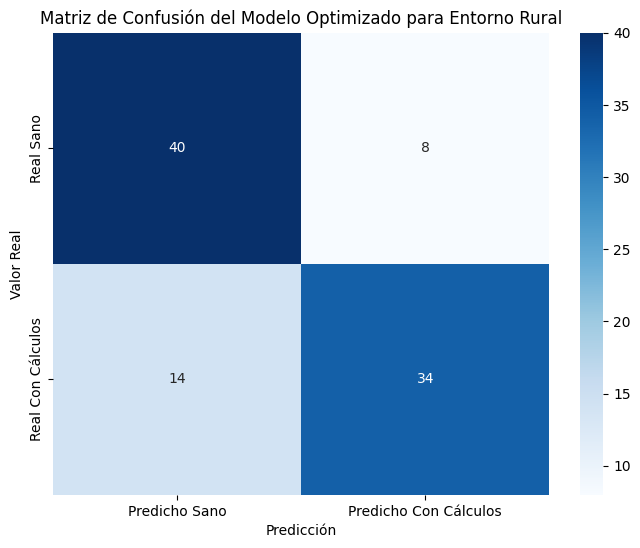


--- Resumen Final Comparativo de Métricas ---


,Estrategia,Test Accuracy,Test AUC
1,GB Optimizado (SMOTE + Optuna),0.7708,0.8138
0,Mejor Benchmark (XGBoost),0.7500,0.8069


In [14]:
# --- 7. ANÁLISIS Y COMPARACIÓN FINAL ---

print(f"--- Análisis Detallado del Modelo Final Optimizado ---")
print("\nReporte de Clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_optuna, target_names=['Sano (0)', 'Con Cálculos (1)']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_optuna)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Sano', 'Predicho Con Cálculos'], yticklabels=['Real Sano', 'Real Con Cálculos'])
plt.title('Matriz de Confusión del Modelo Optimizado para Entorno Rural')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Resumen Comparativo
print("\n--- Resumen Final Comparativo de Métricas ---")
accuracy_base = resultados_benchmark_df.iloc[0]['Test Accuracy']
auc_base = resultados_benchmark_df.iloc[0]['Test AUC']
mejor_modelo_nombre = resultados_benchmark_df.iloc[0]['Modelo']

summary_data = {
    "Estrategia": [
        f"Mejor Benchmark ({mejor_modelo_nombre})",
        "GB Optimizado (SMOTE + Optuna)"
    ],
    "Test Accuracy": [f"{accuracy_base:.4f}", f"{optuna_accuracy:.4f}"],
    "Test AUC": [f"{auc_base:.4f}", f"{optuna_auc:.4f}"]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df.sort_values(by='Test Accuracy', ascending=False))


--- ¿Qué mediciones son más importantes para predecir cálculos en un entorno rural? ---

Gráfico de Importancia de Características SHAP (Bar Plot):
Muestra el impacto promedio absoluto de cada característica. Las más altas son las más importantes.


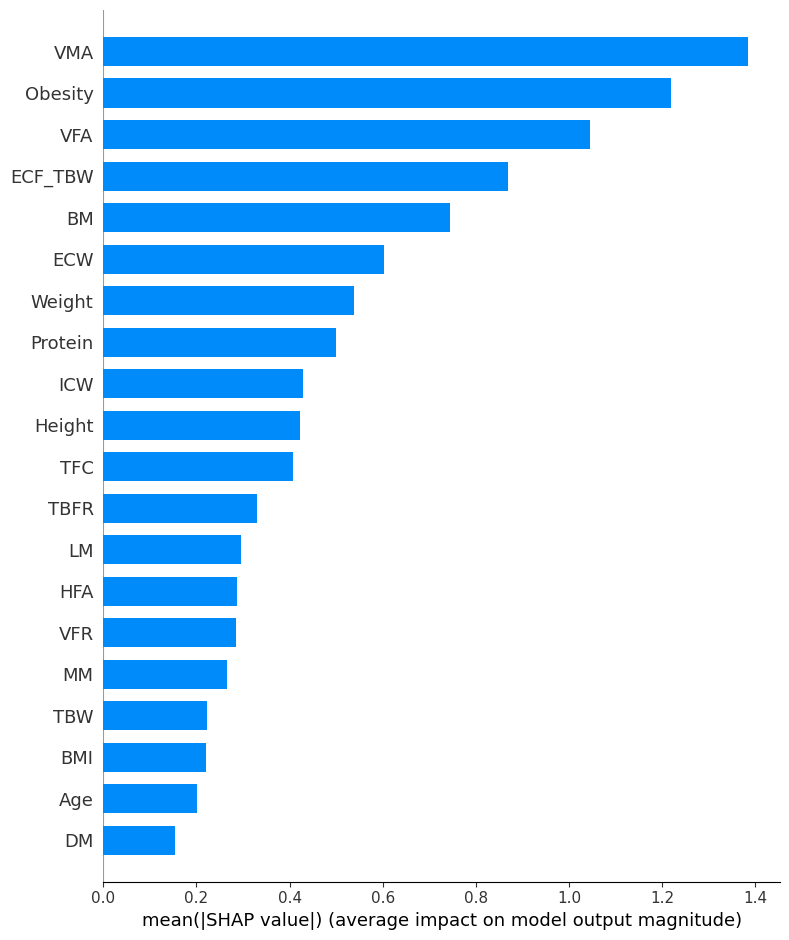


Gráfico de Resumen de SHAP (Beeswarm):
Muestra el impacto de cada característica para cada paciente.
- Eje X: Valor SHAP (impacto en la predicción. >0 aumenta la prob. de tener cálculos).
- Color: Valor de la característica (rojo=alto, azul=bajo).


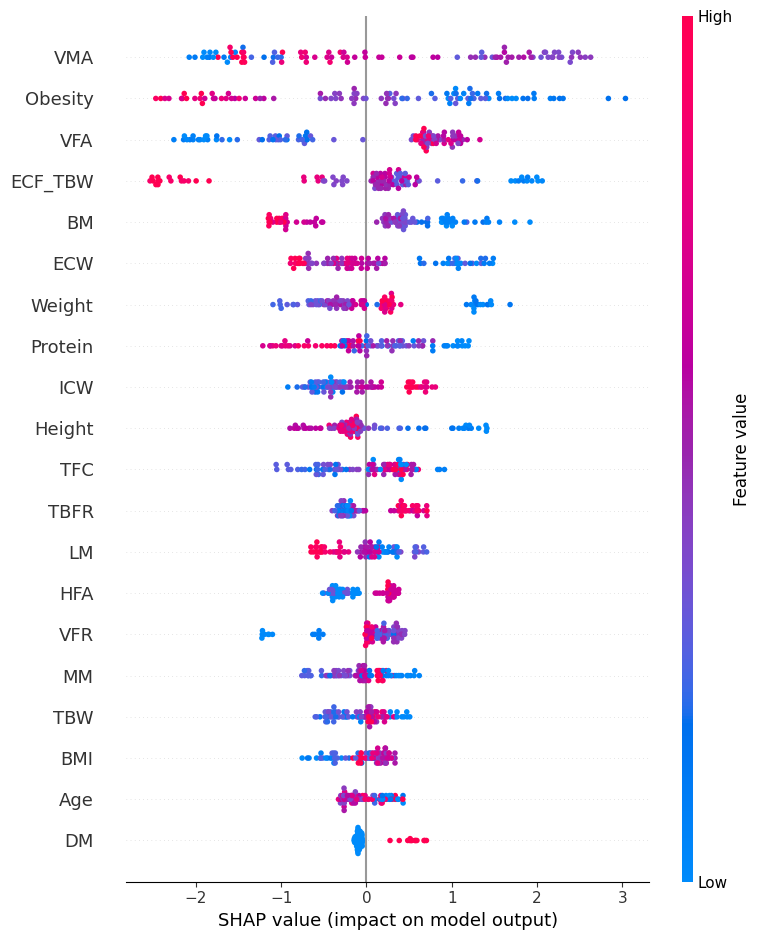

In [15]:
# --- 8. INTERPRETABILIDAD DEL MODELO CON SHAP ---
print("\n--- ¿Qué mediciones son más importantes para predecir cálculos en un entorno rural? ---")

# El explainer se 'ajusta' con los datos de entrenamiento (con SMOTE) para aprender el comportamiento del modelo
explainer = shap.TreeExplainer(final_model_optuna)

# --- CORRECCIÓN ---
# Se calcula los valores SHAP sobre el conjunto de prueba.
# Añadimos check_additivity=False para evitar el error de precisión con modelos de Gradient Boosting.
shap_values = explainer.shap_values(X_test_scaled, check_additivity=False)


print("\nGráfico de Importancia de Características SHAP (Bar Plot):")
print("Muestra el impacto promedio absoluto de cada característica. Las más altas son las más importantes.")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type='bar')

print("\nGráfico de Resumen de SHAP (Beeswarm):")
print("Muestra el impacto de cada característica para cada paciente.")
print("- Eje X: Valor SHAP (impacto en la predicción. >0 aumenta la prob. de tener cálculos).")
print("- Color: Valor de la característica (rojo=alto, azul=bajo).")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)